## Parte 2 - Logistic Regression

In [1]:
#notebook settings
%matplotlib inline

#import some useful libraries and utilities
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold

#data directory
path = './credit/'

#parameters to try
params = np.array([0.2e-3, 0.4e-3, 0.6e-3, 0.8e-3, 1.0e-3])

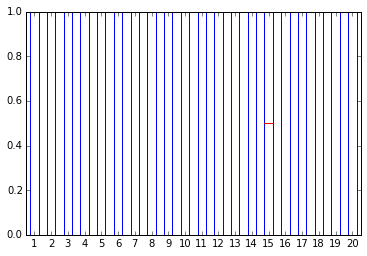

In [2]:
#generating boxplots for second dataset
data = np.empty((90,20))
for i in range(20):
    tr_file = path+'credit-tr-{0}.npy'.format(i)
    tr_data = np.load(tr_file)
    data[:,i] = tr_data[:,-1]
plt.boxplot(data)
plt.show()

In [3]:
#helper functions
def rescale(M,a,b):
    """ Rescale features of M to [a,b] range """
    #max and min vectors
    maxv = np.max(M, axis=0)
    minv = np.min(M, axis=0)
    return (b-a)*M/(maxv-minv) + (a*maxv-b*minv)/(maxv-minv)

def normalize(M):
    #mean and standard deviation vectors
    meanv = np.mean(M, axis=0)
    stdv = np.std(M, axis=0)
    return (M-meanv)/stdv

In [4]:
""" Find the best learning parameter for algorithm, between 
parameters in params using k-fold cross validation """
def find_best(X, y, algorithm, params, mode=None):
    #creating kfold
    m,n = X.shape
    kf = KFold(m, n_folds=5)
    tr_cost = list()
    ts_cost = list()
    
    for param in params:
        mean_tr_cost = 0
        mean_ts_cost = 0
        for tr_index,ts_index in kf:
            X_train, X_test = X[tr_index], X[ts_index]
            y_train, y_test = y[tr_index], y[ts_index]
            beta,_ = algorithm(X_train, y_train, alpha=param)
            mean_tr_cost += J(X_train, y_train, beta)
            mean_ts_cost += J(X_test, y_test, beta)
        tr_cost.append(mean_tr_cost/5)
        ts_cost.append(mean_ts_cost/5)
    if mode=='verbose':
        #print some info
        print 'Mean training errors for each alpha:'
        print tr_cost
        print 'Mean testing errors for each alpha:'
        print ts_cost
    return params[np.argmin(np.array(ts_cost))]

### Mean functions

In [66]:
#Sigmoid function
def sigmoid(z):
    return 1./(1.+np.exp(-z))

#Overall cost function for logistic regression (log likelihood function)
def l(X, y, beta):
    tmp = np.dot(X,beta)
    return (y*tmp - np.log(1.+np.exp(tmp))).sum()

#Error rate for logistic regression
def error_rate(X, y, beta):
    h = np.round(sigmoid(np.dot(X,beta)))
    h = h.astype(int)
    y = y.astype(int)
    m, = h.shape
    return np.logical_xor(h,y).sum()/np.float(m)

#Stochastic gradient ascent for logistic regression
def gd_stochastic(X, y, alpha, eps=1e-10, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    l1 = l(X, y, beta)
    for i in range(max_iter):
        l0 = l1
        for m in range(M):
            beta += alpha*(y[m]-sigmoid(np.dot(X[m],beta)))*X[m]
        #little trick
        #beta /= np.linalg.norm(beta)
        l1 = l(X,y,beta)
        if np.abs(l1-l0)/np.abs(l0) < eps: break
    return (beta,i+1)

#Newton-Raphson method for logistic regression
def nr_logistic(X, y, eps=1e-10, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    l1 = l(X, y, beta)
    for i in range(max_iter):
        l0 = l1
        h = sigmoid(np.dot(X,beta))
        W = np.diag(h*(1-h))
        Hess = -1.*np.dot(X.T, np.dot(W, X))
        Dl = np.dot(X.T, y-h)
        #when it converges, Hess became singular
        try:
            beta -= 0.5*np.linalg.solve(Hess, Dl)
        except np.linalg.LinAlgError:
            break
        #little trick
        #beta /= np.linalg.norm(beta)
        l1 = l(X, y, beta)
        if np.abs(l1-l0)/np.abs(l0) < eps: break
    return (beta,i+1)

In [69]:
#working array
wa = np.load(path+'credit-tr-0.npy')
#X = wa[:,:-1]
X = rescale(wa[:,:-1], 0., 1.)
#X = normalize(wa[:,:-1])
m,n = X.shape
X = np.concatenate((np.ones((m,1)),X),axis=1)
y = np.ascontiguousarray(wa[:,-1])

In [70]:
beta1,it = nr_logistic(X, y)
print 'Beta:', beta1
print 'N° Iter:', it
print 'Error rate:', error_rate(X,y,beta1)

Beta: [  411.26356645   570.51166862 -3349.5693266   -754.90685654  7149.88859955
 -2267.05710566   102.67103279]
N° Iter: 94
Error rate: 0.0


/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: overflow encountered in exp
/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: invalid value encountered in double_scalars


In [71]:
beta2,it = gd_stochastic(X, y, 1e-3)
print 'Beta:', beta2
print 'N° iter:', it
print 'Error rate:', error_rate(X,y,beta2)

Beta: [ -1.04890077   4.1059542  -11.02009917  -1.60264862  32.4600028
 -11.02437294   1.40841336]
N° iter: 100000
Error rate: 0.0222222222222
